# Power Flow Calculations With Tap Changer on High Voltage side

The test bench consists of two nodes, a two winding transformer and a load at the low voltage port of the transformer.
We sweep through tap positions and active power consumption of the load, respectively. This is meant to get an insight
into the results of the transformer, that are achieved with SIMONA.

## Definition of examination parameters
Define some important parameters for the later assessment.

In [1]:
from typing import Dict, List
from uuid import UUID

from tcv.calculation.powersystemdatamodel import ResultCollector

tap_min: int = -10
tap_max: int = 10
tap_range = range(tap_min, tap_max + 1)
v_rated_hv = 10.0
v_rated_lv = 0.4

## Correct tapping in no-load situation
Check, if the transformer adjusts nodal voltages correctly, when not being loaded at all.

### Read no load results

In [2]:
v_lv_pu = []

tap_to_base_directory: Dict[int, str] = ResultCollector.tap_pos_to_base_directory(tap_range,
                                                                                  '../../../results/two_winding/simona/no_load/tap_hv/examination_tap_%i')

no_load_results: List[dict] = ResultCollector.collect_two_winding(tap_to_base_directory=tap_to_base_directory,
                                                      node_a=UUID('6d29f8e6-2aa1-44c9-b7b2-ac4df893e963'),
                                                      node_b=UUID('245d928f-52cb-48de-91a2-ffc43cb4aaf5'),
                                                      load=UUID('b8b9a78e-7200-4c8b-9172-35e28046794c'),
                                                      v_rated_hv=v_rated_hv, v_rated_lv=v_rated_lv)

for no_load_result in no_load_results:
    v_lv_pu.append(no_load_result['result'].v_lv_pu)

### Assess the results

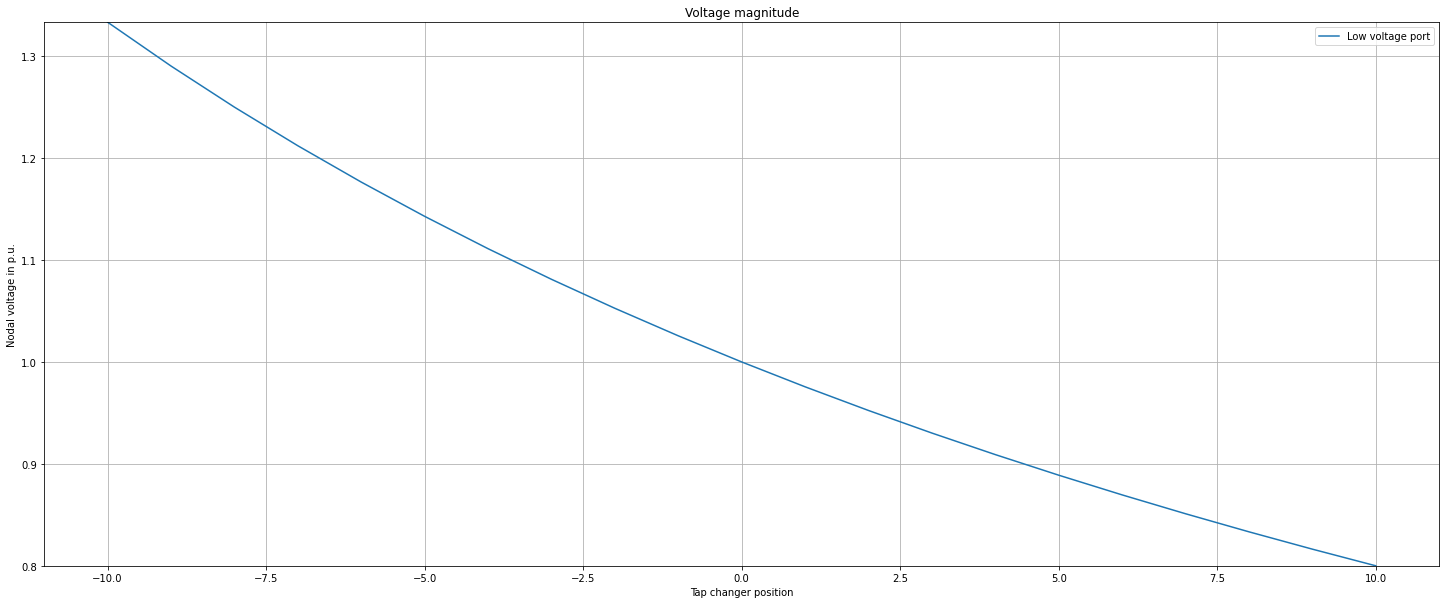

In [3]:
from matplotlib import pyplot as plt
import numpy as np

v_min = min(v_lv_pu)
v_max = max(v_lv_pu)

fig, ax = plt.subplots(figsize=(25, 10))
ax.set_title('Voltage magnitude')
ax.set_xlabel('Tap changer position')
ax.set_ylabel('Nodal voltage in p.u.')
ax.set_ylim(v_min, v_max)
ax.grid()
ax.plot(np.array(tap_range), np.array(v_lv_pu), label='Low voltage port')
ax.legend()

## Correct tapping in loaded situation

The low voltage load is varied within the range of +/- 630 kVA.

### Perform power flow calculations

In [4]:
# Specify information about persisted entities
import json
import os

from tcv.encoder import CustomDecoder
from tcv.encoder.DictEncoder import DictEncoder

result_directory = os.path.join("..", "..", "..", "results", "two_winding")
result_file = os.path.join(result_directory, "simona_tapHv.json")

if os.path.exists(result_file):
    # The result file exists. Read it and use it
    print("Pre-calculated results are available. Load them.")
    with open(result_file, "r") as file_to_read:
        json_string = file_to_read.read()
        results = json.loads(json_string, object_hook=CustomDecoder.custom_decode)
else:
    # Result file doesn't exist. Read the raw information
    tap_to_base_directory: Dict[int, str] = ResultCollector.tap_pos_to_base_directory(tap_range,
                                                                                      '../../../results/two_winding/simona/loaded/tap_hv/examination_tap_%i')
    results: list = ResultCollector.collect_two_winding(tap_to_base_directory=tap_to_base_directory,
                                                      node_a=UUID('6d29f8e6-2aa1-44c9-b7b2-ac4df893e963'),
                                                      node_b=UUID('245d928f-52cb-48de-91a2-ffc43cb4aaf5'),
                                                      load=UUID('b8b9a78e-7200-4c8b-9172-35e28046794c'),
                                                      v_rated_hv=v_rated_hv, v_rated_lv=v_rated_lv)

    if not os.path.exists(result_directory):
        os.makedirs(result_directory)
    with open(result_file, "w") as file_to_write_to:
        json.dump(results, file_to_write_to, cls=DictEncoder, indent=2)


### Assess the results

#### Nodal voltages in neutral tap position

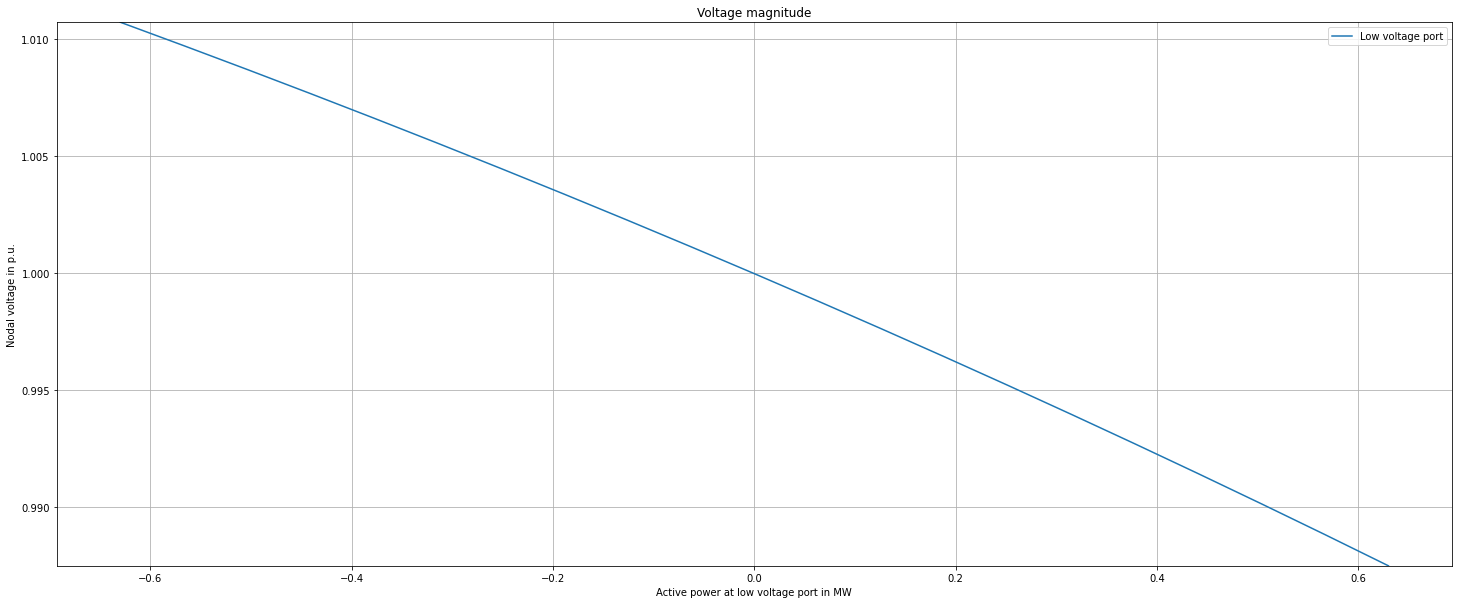

In [5]:
# --- Extract all information from results ---
p_lv_mw = []  # Power at low voltage node
p_hv_mw = {str(tap_pos): [] for tap_pos in tap_range}  # Active power at high voltage node
q_hv_mvar = {str(tap_pos): [] for tap_pos in tap_range}  # Reactive power at high voltage node
v_lv_pu = {str(tap_pos): [] for tap_pos in tap_range}  # Voltage magnitude at low voltage node
for result in results:
    tap_pos = result['tap_pos']
    idx = str(tap_pos)

    # Only register the input values in one tap position
    if tap_pos == 0:
        p_lv_mw.append(result['p_lv'])

    # Register nodal voltages and resulting joint power for all tap positions
    v_lv_pu[idx].append(result['result'].v_lv_pu)
    p_hv_mw[idx].append(result['result'].p_hv_kw / 1000)
    q_hv_mvar[idx].append(result['result'].q_hv_kvar / 1000)

v_min = {key: min(voltages) for key, voltages in v_lv_pu.items()}
v_max = {key: max(voltages) for key, voltages in v_lv_pu.items()}

fig_neutral_tap_v, ax_neutral_tap_v = plt.subplots(figsize=(25, 10))
ax_neutral_tap_v.set_title('Voltage magnitude')
ax_neutral_tap_v.set_xlabel('Active power at low voltage port in MW')
ax_neutral_tap_v.set_ylabel('Nodal voltage in p.u.')
ax_neutral_tap_v.set_ylim(v_min['0'], v_max['0'])
ax_neutral_tap_v.grid()
ax_neutral_tap_v.plot(np.array(p_lv_mw), np.array(v_lv_pu['0']), label='Low voltage port')
ax_neutral_tap_v.legend()

##### Conclusions
-   The higher the power consumption, the lower the nodal voltages.
-   Nodal voltage is 1.0 p.u. at both ports for the no-load situation.
    This meets expectations for a two winding transformer.

#### Nodal voltages for different tap positions
Specifically, at tap position -10, -5, 0, 5, 10.

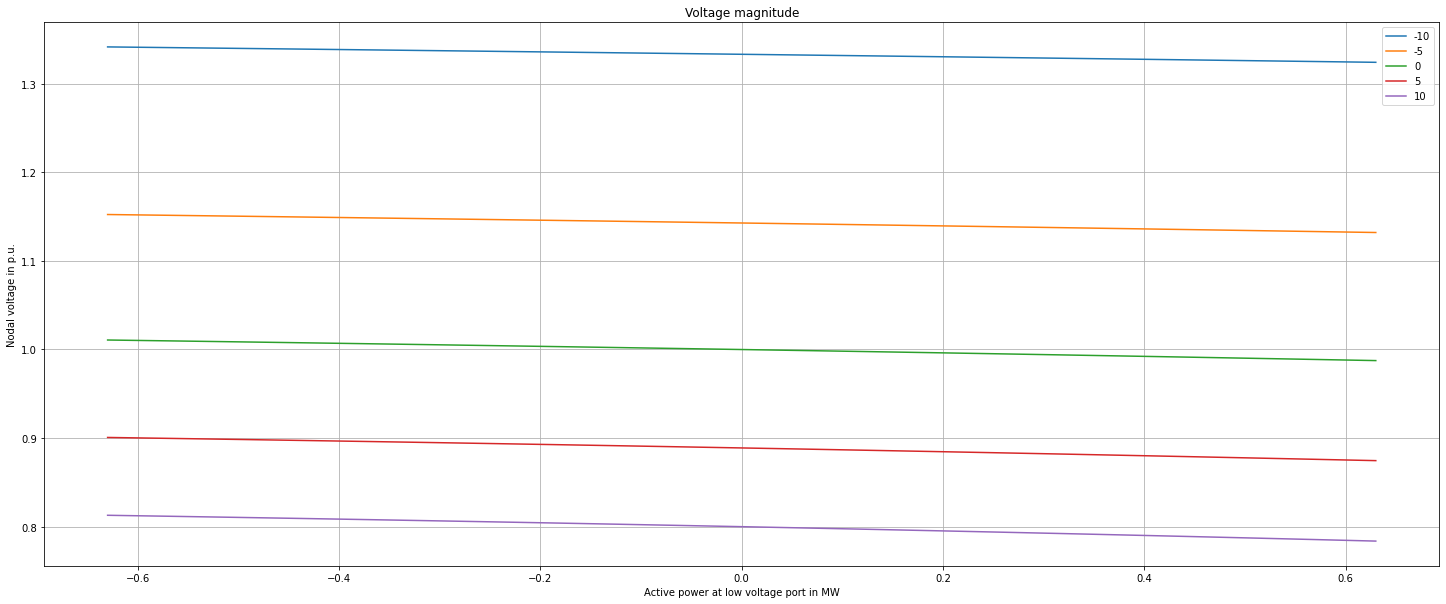

In [6]:
fig_tap_v, ax_tap_v = plt.subplots(figsize=(25, 10))
ax_tap_v.set_title('Voltage magnitude')
ax_tap_v.set_xlabel('Active power at low voltage port in MW')
ax_tap_v.set_ylabel('Nodal voltage in p.u.')
ax_tap_v.grid()
ax_tap_v.plot(np.array(p_lv_mw), np.array(v_lv_pu['-10']), label='-10')
ax_tap_v.plot(np.array(p_lv_mw), np.array(v_lv_pu['-5']), label='-5')
ax_tap_v.plot(np.array(p_lv_mw), np.array(v_lv_pu['0']), label='0')
ax_tap_v.plot(np.array(p_lv_mw), np.array(v_lv_pu['5']), label='5')
ax_tap_v.plot(np.array(p_lv_mw), np.array(v_lv_pu['10']), label='10')
ax_tap_v.legend()

plt.show()

##### Conclusions
-   Overall nodal voltages rise with lowering tap changer position
-   The lower the tap changer position, the higher the impact of one step-change
-   Voltage curve maintain a similar shape
    -   Curvature is higher for lower voltages
    -   This is, because the same power is served with a higher current and therefore, the voltage drop across the
        transformer is higher